Projeto de Verão
==
Introdução a Python
--
Feito por: Silvana Barboza

In [6]:
import ccxt
import datetime
from sqlalchemy import create_engine
import sqlite3 
import poloniex

### Definindo as variáveis


In [7]:
symbol1 = 'BTC_MAID'
symbol2 = 'BTC_STR'

### Pegando os valores
#### Pega os valores referente a um ano da classe criada pelo professor


In [69]:
now = datetime.datetime.now()
yearAgo = now - datetime.timedelta(days=365)

In [ ]:
data1 = poloniex.get_ohlc(symbol1, yearAgo, now)
data2 = poloniex.get_ohlc(symbol2, yearAgo, now)

### Salvando no banco de dados


In [8]:
conn = create_engine('sqlite:///summer_project.sqlite')

In [5]:
data1.to_sql(symbol1, conn, if_exists='replace')
data2.to_sql(symbol2, conn, if_exists='replace')

NameError: name 'data1' is not defined

# Gráficos


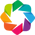

In [1]:
#---imports---#
import holoviews as hv
from holoviews.operation.timeseries import rolling
import numpy as np
import pandas as pd
hv.extension('bokeh')
hv.Dimension.type_formatters[np.datetime64] = '%m/%y'

In [2]:
##Opts
plot_opts = dict(fig_size=200, legend_position='top_left', width=700)
color_cycle = hv.Cycle(values=['#4169E1', '#2E8B57'])
hv.Store.options(backend='bokeh').Curve = hv.Options('style', color=color_cycle)

#### Pegar valores do banco de dados


In [9]:
conn = create_engine('sqlite:///summer_project.sqlite')
data1 = pd.read_sql(symbol1, conn)
data2 = pd.read_sql(symbol2, conn)

## Gráfico 1
### Preços de fechamento das moedas 


In [10]:
def close_prices(symbol, **kwargs):
    return hv.Curve(dic_data[symbol] , ('date', 'Date'), ('close', 'Close price'))

stock_symbols = [symbol1, symbol2,]
dic_data = {symbol1: data1, symbol2:data2}
dynamicMap = hv.DynamicMap(close_prices, kdims='Symbol').redim.values(Symbol=stock_symbols).opts(plot=plot_opts)

In [11]:
%%opts Curve [width=700] {+framewise}
dynamicMap

:DynamicMap   [Symbol]

### Relação entre o preço de fechamento entre as duas moedas

##### - Gráfico interativo mostrando a relacão entre o valor de fechamento das duas moedas dos últimos 2000 registros

In [12]:
%%opts Curve [width=700, height=500, show_grid=True] {+framewise}
def relation_curve(w, **kwargs): 
    curve1 = hv.Curve(data1[-w:], ('date', 'Date'), ('close', 'Price'), label=symbol1)
    curve2 = hv.Curve(data2[-w:], ('date', 'Date'), ('close', 'Price'), label=symbol2)
    return (curve1 * curve2).opts(plot=plot_opts)
maxSize = 2000;   
winsize = {c:relation_curve(c) for c in range(10,maxSize,50)}
hv.HoloMap(winsize, kdims='Window size')

:HoloMap   [Window size]
   :Overlay
      .Curve.BTC_MAID :Curve   [date]   (close)
      .Curve.BTC_STR  :Curve   [date]   (close)

##### - Gráfico com mais registros, porém sem interação

In [ ]:
curve1 = hv.Curve(data1[-50000:], ('date', 'Date'), ('close', 'Price'), label=symbol1)
curve2 = hv.Curve(data2[-50000:], ('date', 'Date'), ('close', 'Price'), label=symbol2)

(curve1 * curve2).opts(plot=plot_opts)

## Gráfico 2
### Visualização dos maiores valores da moeda durante o mês

In [14]:
def get_highest_value_by_month(dataframe):
    df = pd.DataFrame(dataframe)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['high'].max()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf


In [14]:
def get_highest_value_by_day(dataframe):
    df = pd.DataFrame(dataframe)
    df['day'] = df.date.dt.to_period('d')
    groupDf = df.groupby(['day'], sort=False, as_index=False)['high'].max()
    groupDf['date'] = groupDf['day'].map(lambda x: x.to_timestamp())
    return groupDf

In [15]:
%%opts Curve [width=200, height=100, show_grid=True] {+framewise}
def load_bars(symbol, **kwargs):
    curve = hv.Curve(get_highest_value_by_month(dic_data[symbol]), ('date', 'Date'), ('high', 'Price'))
    return hv.Bars(curve)

stock_symbols = [symbol1, symbol2,]
dic_data = {symbol1: data1, symbol2:data2}
plot_opts = dict( width=500)
dynamicMap = hv.DynamicMap(load_bars, kdims='Symbol').redim.values(Symbol=stock_symbols).opts(plot=plot_opts)
dynamicMap

:DynamicMap   [Symbol]

In [16]:
curve1 = hv.Curve(get_highest_value_by_month(data1), ('date', 'Date'), ('high', 'Price'), label=symbol1)
bars1 = hv.Bars(curve1)

curve2 = hv.Curve(get_highest_value_by_month(data2), ('date', 'Date'), ('high', 'Price'), label=symbol2)
bars2 = hv.Bars(curve2)

bars_graphic = (bars1 + bars2)

#### Gráfico de barras lado a lado para fim de comparação entre duas moedas

In [17]:
bars_graphic

:Layout
   .Bars.BTC_MAID :Bars   [date]   (high)
   .Bars.BTC_STR  :Bars   [date]   (high)

## Gráfico 3
### Relação entre o maior e o menor preço de venda no mês

In [12]:
def get_lowest_value_by_month(dataframe):
    df = pd.DataFrame(dataframe)
    df['month'] = df.date.dt.to_period('M')
    groupDf = df.groupby(['month'], sort=False, as_index=False)['low'].min()
    groupDf['date'] = groupDf['month'].map(lambda x: x.to_timestamp())
    return groupDf

In [36]:
def low_and_high(symbol, **kwargs):
    area1 = hv.Area(hv.Curve(get_highest_value_by_month(dic_data[symbol]), 'date', 'high', label=symbol1))
    area2 = hv.Area(hv.Curve(get_lowest_value_by_month(dic_data[symbol]), 'date', 'low', label=symbol1))
    return (area1 * area2)

stock_symbols = [symbol2, symbol1]
dic_data = {symbol1: data1, symbol2:data2}
dynamicMap = hv.DynamicMap(low_and_high, kdims='Symbol').redim.values(Symbol=stock_symbols).opts(plot=plot_opts)

#### - Gráfico com opção de selecionar o tipo de moeda

In [37]:
dynamicMap

:DynamicMap   [Symbol]

## Gráfico 4
### Volume de Diário

In [44]:
def get_sum_volume_by_day(dataframe):
    df = pd.DataFrame(dataframe)
    df['day'] = df.date.dt.to_period('d')
    groupDf = df.groupby(['day'], sort=False, as_index=False)['volume'].sum()
    groupDf['date'] = groupDf['day'].map(lambda x: x.to_timestamp())
    return groupDf


In [45]:
def get_volume_by_hour(dataframe):
    df = pd.DataFrame(dataframe)
    df['hour'] = df.date.dt.to_period('h')
    print(df.date.dt.to_period('h'))
    groupDf = df.groupby(['hour'], sort=False, as_index=False)['volume']
    groupDf['date'] = groupDf['hour'].map(lambda x: x.to_timestamp())
    return groupDf

In [46]:
def get_one_month_data(dataframe):
    today = datetime.datetime.today()
    monthAgo = now - datetime.timedelta(days=30)
    dataframe.index = dataframe['date']
    return dataframe[monthAgo: today]   

In [63]:
curveSumVolume1 = hv.Curve(get_sum_volume_by_day(data1), 'date', 'volume', label=symbol1)
curveSumVolume2= hv.Curve(get_sum_volume_by_day(data2), 'date', 'volume', label=symbol2)

curveVolume = (curveSumVolume1 + curveSumVolume2)

#### Gráfico comparativo de volume entre duas moedas

In [64]:
%%opts Curve [width=400, height=400, show_grid=True] {+framewise}
curveVolume

:Layout
   .Curve.BTC_MAID :Curve   [date]   (volume)
   .Curve.BTC_STR  :Curve   [date]   (volume)

## Gráfico 5
### Hora do menor valor do dia dos últimos 30 dias

In [75]:
def get_lowest_value_by_day(dataframe):
    df = pd.DataFrame(dataframe)
    df['day'] = df.date.dt.to_period('d')
    groupDf = df.groupby(['day'], sort=False)['low'].max()
    df['count_max'] = df.groupby(['day'])['low'].transform(max)
    df['time'] = df.date.dt.time
    return df[df['low'] == df['count_max']]

In [76]:
lowest1 = get_lowest_value_by_day(get_one_month_data(data1))
lowest2 = get_lowest_value_by_day(get_one_month_data(data2))

scatterOpts = dict(fig_size=200, legend_position='top_left', )
(hv.Scatter(lowest1, 'date', 'time', label=symbol1)).opts(plot=scatterOpts)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

:Scatter   [date]   (time)